# Clasificacion de Pistachos

En este trabajo se intentara clasificar la variedad de pistacho a partir de multiples caracteristicas acerca la morfologia y forma de estos. Especificamente las variedades `Siit` y `Kirmizi`.

Para ello aplicaremos multiples tecnicas de clasificacion, mas exactamente: regresion logistica, K vecinos mas cercanos, con maquina de soporte vectorial, Naive Bayes, Arboles de decision, Random Forest y (como bonus) con una red neuronal, luego se compararan los resultados obtenidos.

El dataset utilizado fue extraido de [Kaggle - pistachio types detection](https://www.kaggle.com/datasets/amirhosseinmirzaie/pistachio-types-detection), datasets similares pueden encontrarse tamien en [Kaggle - pistachio image dataset](https://www.kaggle.com/datasets/muratkokludataset/pistachio-image-dataset)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix, precision_score, accuracy_score,
    recall_score, f1_score, roc_auc_score, classification_report,
    )
import random # para tener colores random
import warnings
warnings.filterwarnings("ignore")

## Revisando el dataset

El dataset a utilizar posee 12 columnas numericas acerca la morfologia de los pistachos:
1. `AREA`
2. `PERIMETER`
3. `MAJOR_AXIS`
4. `MINOR_AXIS`
5. `ECCENTRICITY`
6. `EQDIASQ`
7. `SOLIDITY`
8. `CONVEX_AREA`
9. `EXTENT`
10. `ASPECT_RATIO`
11. `ROUNDNESS`
12. `COMPACTNESS`

Tambien posee 5 columnas numericas acerca de la forma de los pistachos:
13. `SHAPEFACTOR_1`
14. `SHAPEFACTOR_2`
15. `SHAPEFACTOR_3`
16. `SHAPEFACTOR_4`

Y una columna indicando cual su variedad, puede ser `kirmizi_pistachio` o `siit_pistachio`.
17. `Class`

A continuacion podemos observar un pistacho con algunas caracteristicas mencionadas:

![pistachio features](./docs/pistachio_features.jpg)

Podemos observar a continuacion muestras de los registros del dataset:

In [3]:
dataset = pd.read_csv('./content/pistachio.csv')
dataset.head()

,AREA,PERIMETER,MAJOR_AXIS,MINOR_AXIS,ECCENTRICITY,EQDIASQ,SOLIDITY,CONVEX_AREA,EXTENT,ASPECT_RATIO,ROUNDNESS,COMPACTNESS,SHAPEFACTOR_1,SHAPEFACTOR_2,SHAPEFACTOR_3,SHAPEFACTOR_4,Class
0,73107,1161.8070,442.4074,217.7261,0.8705,305.0946,0.9424,77579,0.7710,2.0319,0.6806,0.6896,0.0061,0.0030,0.4756,0.9664,Kirmizi_Pistachio
1,89272,1173.1810,460.2551,251.9546,0.8369,337.1419,0.9641,92598,0.7584,1.8267,0.8151,0.7325,0.0052,0.0028,0.5366,0.9802,Siit_Pistachio
2,60955,999.7890,386.9247,209.1255,0.8414,278.5863,0.9465,64400,0.7263,1.8502,0.7663,0.7200,0.0063,0.0034,0.5184,0.9591,Kirmizi_Pistachio
3,79537,1439.5129,466.7973,221.2136,0.8806,318.2289,0.9437,84281,0.7568,2.1102,0.4823,0.6817,0.0059,0.0028,0.4648,0.9807,Kirmizi_Pistachio
4,96395,1352.6740,515.8730,246.5945,0.8784,350.3340,0.9549,100950,0.7428,2.0920,0.6620,0.6791,0.0054,0.0026,0.4612,0.9648,Kirmizi_Pistachio


## Preprocesado de datos y Analisis Exploratorio

A continuacion analizaremos el dataset para ver si es necesario realizar algun tipo de preprocesamiento para eliminar outliers o balancear el dataset, tambien analizaremos que correlaciones podemos encontrar entre las variables.

### Balanceo de datos

Empezemos analizando cuantos datos tenemos de cada clase de pistacho, esto es importante para saber si debemos balancear el dataset o no.

De no estar balanceado el dataset, podriamos tener problemas a la hora de entrenar los modelos, ya que podrian aprender a clasificar solo una clase y no la otra.

Ademas de esto, podria ocasionar que obtengamos una precision erronea, ya que si tenemos 90% de pistachos A y 10% de pistachos B, un modelo que siempre clasifique a todos por A tendria un 90% de precision, pero no seria un buen modelo.

([<matplotlib.patches.Wedge at 0x7f5236cd8a00>,
 [Text(-0.2765972019687502, 1.0646567464976957, 'Kirmizi'),
  Text(0.2765973016491072, -1.064656720600792, 'Siit')],
 [Text(-0.15087120107386373, 0.5807218617260157, '58.1%'),
  Text(0.15087125544496752, -0.580721847600432, '41.9%')])

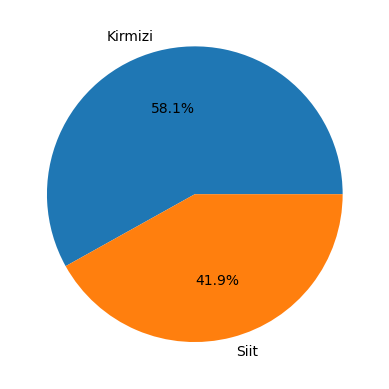

In [4]:
plt.pie(
    dataset['Class'].value_counts(),
    labels=['Kirmizi', 'Siit'],
    autopct='%1.1f%%',
    )

Podemos observar que la cantidad de pistachos de cada clase es mas o menos similar, cercanos al 50% de cada variedad, por lo cual no es necesario balancear el dataset.

### Outliers

todo

In [5]:
## TODO: outliers

### Correlaciones

todo

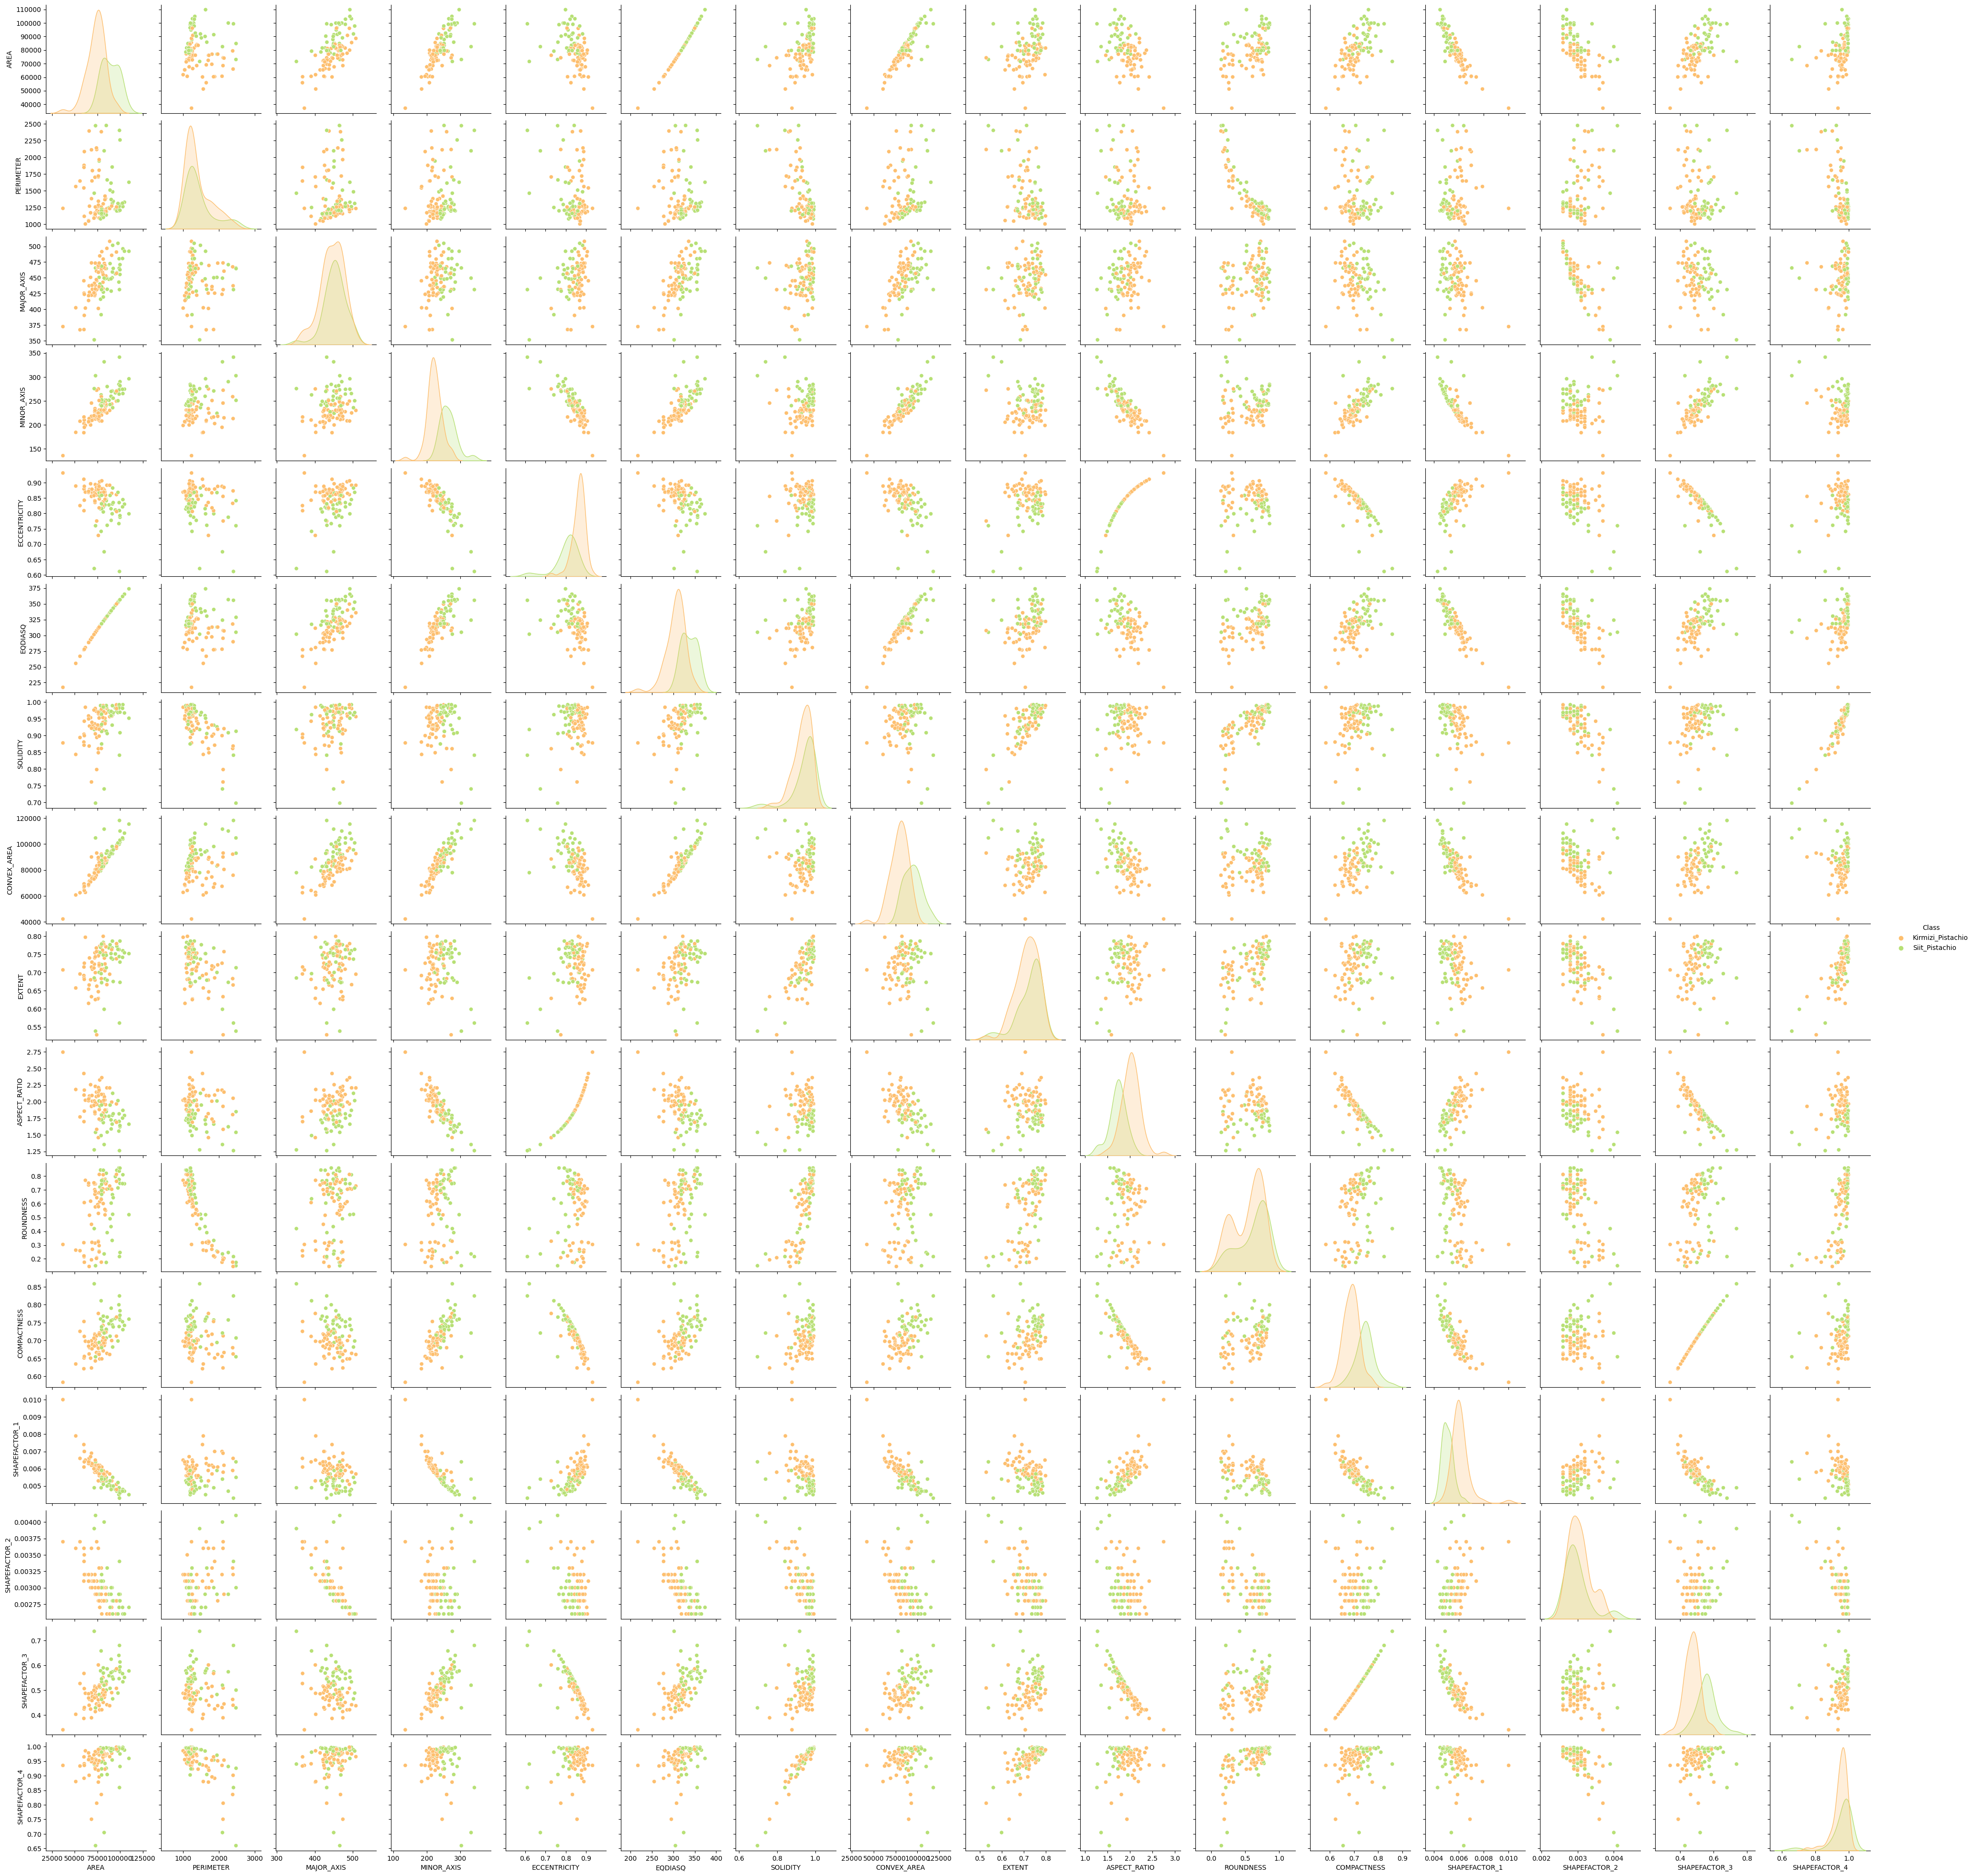

In [6]:
columnas = [
    'AREA', 'PERIMETER', 'MAJOR_AXIS',
    'MINOR_AXIS', 'ECCENTRICITY', 'EQDIASQ',
    'SOLIDITY', 'CONVEX_AREA', 'EXTENT',
    'ASPECT_RATIO', 'ROUNDNESS', 'COMPACTNESS',
    'SHAPEFACTOR_1', 'SHAPEFACTOR_2', 'SHAPEFACTOR_3',
    'SHAPEFACTOR_4',
]
sns.pairplot(
    dataset.sample(100),
    hue='Class',
    vars=columnas,
    palette='RdYlGn',
    )
plt.show()

todo

In [7]:
dataset['Kirmizi'] = dataset['Class'].apply(lambda x: 1 if x == 'Kirmizi_Pistachio' else 0)

### Definiendo las variables dependientes e independientes

Como variable independiente X utilizaremos las 16 columnas numericas acerca las diferentes caracteristicas de los pistachos, y como variable dependiente Y utilizaremos la columna `Class` que es la que necesitamos predecir.

In [8]:
X = dataset.iloc[:, :15].values
y = dataset['Kirmizi'].values
X, y

(array([[7.3107000e+04, 1.1618070e+03, 4.4240740e+02, ..., 6.1000000e-03,
         3.0000000e-03, 4.7560000e-01],
        [8.9272000e+04, 1.1731810e+03, 4.6025510e+02, ..., 5.2000000e-03,
         2.8000000e-03, 5.3660000e-01],
        [6.0955000e+04, 9.9978900e+02, 3.8692470e+02, ..., 6.3000000e-03,
         3.4000000e-03, 5.1840000e-01],
        ...,
        [9.0270000e+04, 1.3705380e+03, 4.2896360e+02, ..., 4.8000000e-03,
         3.0000000e-03, 6.2460000e-01],
        [7.3148000e+04, 1.3098430e+03, 4.6904910e+02, ..., 6.4000000e-03,
         2.8000000e-03, 4.2330000e-01],
        [7.8780000e+04, 1.3248831e+03, 4.5159050e+02, ..., 5.7000000e-03,
         3.0000000e-03, 4.9190000e-01]]),
 array([1, 0, 1, ..., 0, 1, 0]))

### Separando datos de entrenamiento y testeo

Separamos los datos en sets para utilizar un porcentaje para el entrenamiento y otro para el testeo del modelo.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.2,
    random_state = 0,
    )

Como ultimo paso en esta etapa vamos estandarizar y escalar los datos

In [10]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
X_train, X_test

(array([[-1.69302884e+00,  8.77954274e-02, -2.31012100e+00, ...,
          8.76868588e-01,  1.76198371e+00,  3.30832225e-01],
        [-2.90099243e-01,  6.41596723e-01, -6.55881123e-01, ...,
         -1.28297698e-01,  2.47555074e-01,  4.03828468e-01],
        [ 1.50325918e+00, -1.56487811e-01,  9.09844469e-01, ...,
         -1.13346398e+00, -9.63987836e-01,  7.94199683e-01],
        ...,
        [ 2.83169083e-01,  1.68256725e+00,  2.20881607e-01, ...,
         -3.79589270e-01,  2.97352662e+00,  1.21364743e-01],
        [-8.83940878e-01, -8.24506826e-01, -1.05528545e+00, ...,
          3.74285445e-01,  8.53326530e-01,  2.29785023e-02],
        [ 1.29101287e-01,  1.48637177e+00,  5.53008654e-01, ...,
         -2.65191251e-03, -3.58216381e-01, -4.35628331e-01]]),
 array([[-1.2239419 , -0.69448357, -0.95813901, ...,  1.00251437,
          0.5504408 , -0.61018457],
        [-0.25057683,  0.5866709 , -0.09328488, ...,  0.12299387,
         -0.05533065, -0.21505273],
        [-0.58307555,  0.

## Clasificacion con regresion logistica

Este metodo de clasificacion basicamente intenta predecir con reglas de la probabilidad que tan probable es que haya un fallo o no, utilizando una funcion sigmoide.

Definimos el modelo y sus parametros

In [11]:
classifier = LogisticRegression(
    random_state = 0,
    )

LogisticRegression(random_state=0)

Entrenamos el modelo

In [ ]:
classifier.fit(X_train, y_train)

Realizamos predicciones a partir de los datos de testeo

In [12]:
y_pred = classifier.predict(X_test)

Podemos observar en la matriz de confusion que se obtuvo una buena cantidad de aciertos para ambas categorias

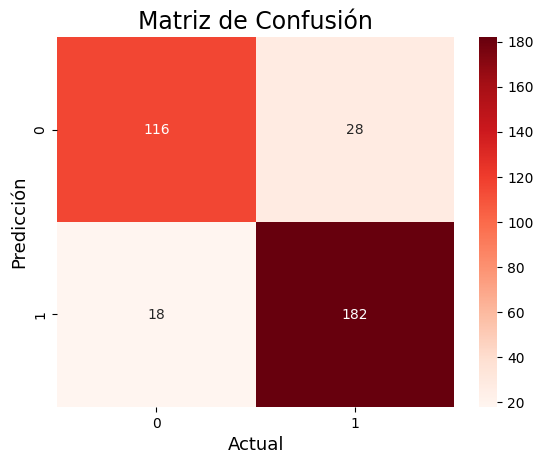

In [13]:
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    palletes = [
        'Blues', 'Reds', 'mako', 'crest',
        ]
    sns.heatmap(
        cm,
        annot=True,
        fmt='g',
        cmap=random.choice(palletes),
        )
    plt.ylabel('Predicción', fontsize=13)
    plt.xlabel('Actual', fontsize=13)
    plt.title('Matriz de Confusión', fontsize=17)
    plt.show()
#
plot_confusion_matrix(y_test, y_pred)

A continuacion podemos observar con mayor detalle las diferentes metricas obtenidas con el modelo

In [14]:
def plot_metricas(y_test, y_pred):
    print(f'Precisión del modelo: {precision_score(y_test, y_pred):.2f}')
    print(f'Exactitud del modelo: {accuracy_score(y_test, y_pred):.2f}')
    print(f'Sensibilidad del modelo: {recall_score(y_test, y_pred):.2f}')
    print(f'Puntaje F1 del modelo: {f1_score(y_test, y_pred):.2f}')
    print(f'Curva ROC - AUC del modelo: {roc_auc_score(y_test, y_pred):.2f}')
#
plot_metricas(y_test, y_pred)

Precisión del modelo: 0.87
Exactitud del modelo: 0.87
Sensibilidad del modelo: 0.91
Puntaje F1 del modelo: 0.89
Curva ROC - AUC del modelo: 0.86


## Clasificacion con KNN

Basicamente este metodo de clasificacion intenta predecir si fallo o no, basandose en que tan cercanos son los datos en un espacio multidimensional.

Comenzamos definiendo el modelo y sus parametros

In [15]:
classifier = KNeighborsClassifier(
    n_neighbors = 5,
    metric = "minkowski",
    p = 2,
    )

KNeighborsClassifier()

Realizamos el entrenamiento del modelo

In [ ]:
classifier.fit(X_train, y_train)

Realizamos predicciones a partir de los datos de testeo

In [16]:
y_pred = classifier.predict(X_test)

Podemos observar que la cantidad de aciertos en muy buena para ambas categorias

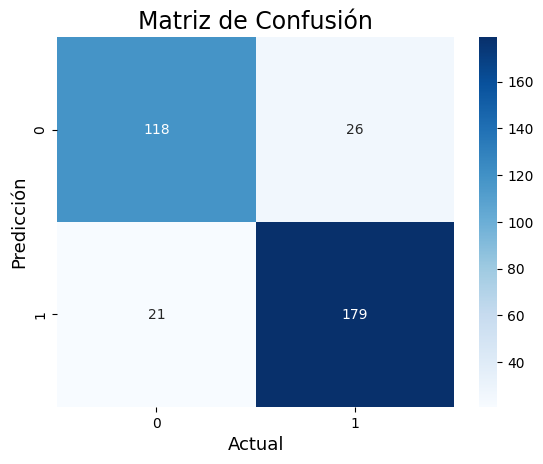

In [17]:
plot_confusion_matrix(y_test, y_pred)

A continuacion podemos observar con mayor detalle las diferentes metricas obtenidas con el modelo

In [18]:
plot_metricas(y_test, y_pred)

Precisión del modelo: 0.87
Exactitud del modelo: 0.86
Sensibilidad del modelo: 0.90
Puntaje F1 del modelo: 0.88
Curva ROC - AUC del modelo: 0.86


## Clasificacion con Maquina de Soporte Vectorial

Basicamente este metodo de clasificacion intenta predecir una categoria, separando los datos con hiperplanos, el negativo y positivo que son los mas cercanos a los datos y el hiperplano optimo que es el intermedio entre ambos.

Definimos el modelo y sus parametros

In [ ]:
classifier = SVC(
    kernel = "rbf",
    random_state = 0,
    )

Entrenamos el modelo

In [19]:
classifier.fit(X_train, y_train)

SVC(random_state=0)

Realizamos las predicciones de testeo

In [20]:
y_pred = classifier.predict(X_test)

Podemos ver que obtuvimos una buena cantidad de aciertos para ambas categorias, lo que indica que el modelo es bueno

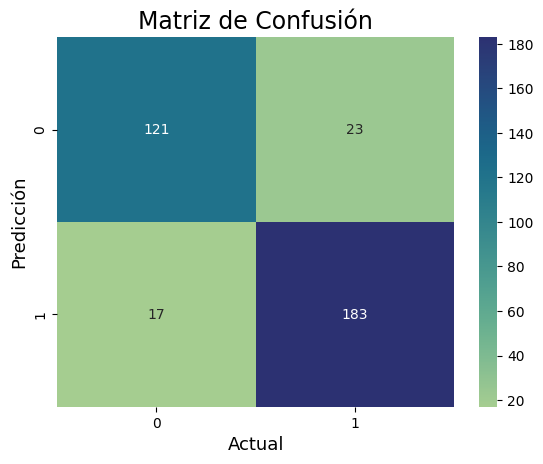

In [21]:
plot_confusion_matrix(y_test, y_pred)

Podemos ver con mayor detalle las diferentes metricas obtenidas con el modelo:

In [22]:
plot_metricas(y_test, y_pred)

Precisión del modelo: 0.89
Exactitud del modelo: 0.88
Sensibilidad del modelo: 0.92
Puntaje F1 del modelo: 0.90
Curva ROC - AUC del modelo: 0.88


## Clasificacion con Naive Bayes

Basicamente este metodo de clasificacion utiliza el Teorema de Bayes, el cual intenta predecir cual es la probabilidad de que un evento ocurra comparando las caracteristicas de este evento vs la probabilidad de que ocurra un evento similar.

Definimos el modelo y sus parametros

In [23]:
classifier = GaussianNB()

GaussianNB()

Realizamos el entrenamiento del modelo

In [ ]:
classifier.fit(X_train, y_train)

Realizamos las predicciones de testeo

In [24]:
y_pred = classifier.predict(X_test)

Podemos ver que el modelo es bueno ya que obtuvimos una buena cantidad de aciertos para ambas categorias

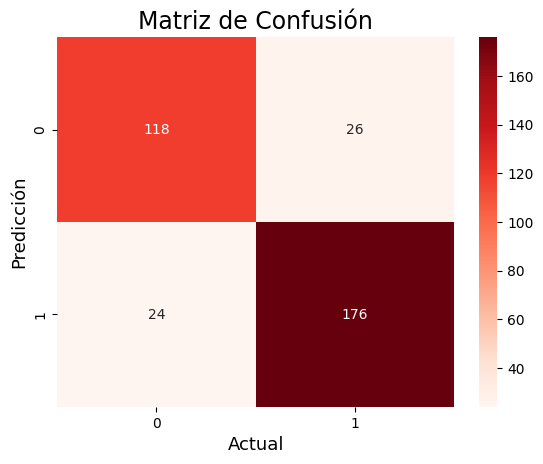

In [25]:
plot_confusion_matrix(y_test, y_pred)

Podemos ver con mayor detalle las diferentes metricas obtenidas con el modelo:

In [26]:
plot_metricas(y_test, y_pred)

Precisión del modelo: 0.87
Exactitud del modelo: 0.85
Sensibilidad del modelo: 0.88
Puntaje F1 del modelo: 0.88
Curva ROC - AUC del modelo: 0.85


## Clasificacion con Arboles de Decision

Este metodo de clasificacion funciona subdividiendo los datos en ramas, siguiendo como criterio el indice de Gini para realizar los cortes en las variables independientes.

Definimos el modelo y sus parametros

In [27]:
classifier = DecisionTreeClassifier(
    criterion = "entropy",
    random_state = 0,
    )

DecisionTreeClassifier(criterion='entropy', random_state=0)

Realizamos el entrenamiento del modelo

In [ ]:
classifier.fit(X_train, y_train)

Realizamos las predicciones de testeo

In [28]:
y_pred = classifier.predict(X_test)

Podemos ver que el modelo es muy bueno ya que obtuvimos una buena cantidad de aciertos para ambas categorias

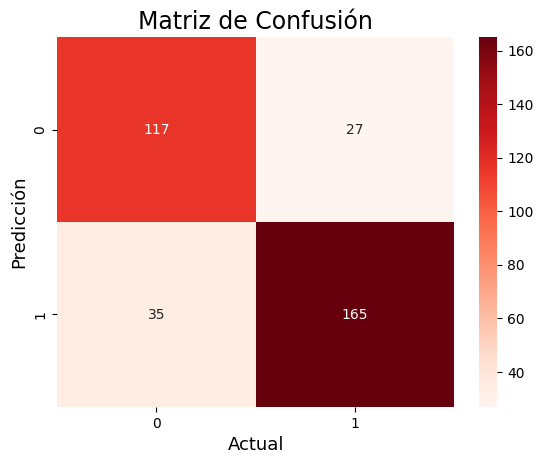

In [29]:
plot_confusion_matrix(y_test, y_pred)

Vemos en detalle las diferentes metricas obtenidas con el modelo:

In [30]:
plot_metricas(y_test, y_pred)

Precisión del modelo: 0.86
Exactitud del modelo: 0.82
Sensibilidad del modelo: 0.82
Puntaje F1 del modelo: 0.84
Curva ROC - AUC del modelo: 0.82


## Clasificacion con Random Forest

Basicamente este metodo combina multiples arboles de decision en un mismo resultado mediante votacion, obteniendo una precision mayor que cada uno de los arboles individualmente. Este tipo de metodos que combinan multiples modelos se denominan [Ensemble Learning](https://en.wikipedia.org/wiki/Ensemble_learning).

In [31]:
classifier = RandomForestClassifier(
    n_estimators = 10,
    criterion = "entropy",
    random_state = 0,
    )

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

Entrenamos el modelo

In [ ]:
classifier.fit(X_train, y_train)

Realizamos las predicciones de testeo

In [32]:
y_pred = classifier.predict(X_test)

Nuevamente podemos observar que la prediccion fue muy buena ya que tenemos bastantes aciertos para cada categoria

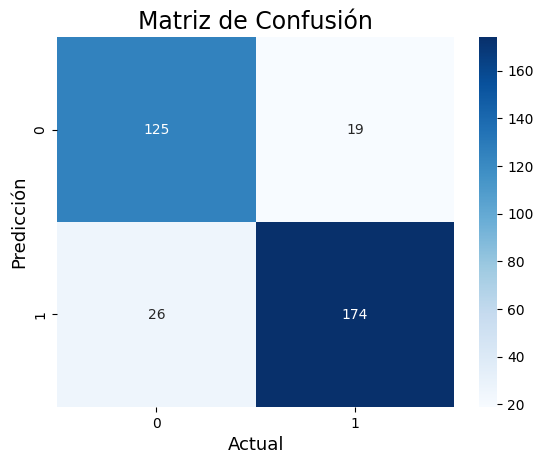

In [33]:
plot_confusion_matrix(y_test, y_pred)

Vemos en detalle las metricas obtenidas con el modelo:

In [34]:
plot_metricas(y_test, y_pred)

Precisión del modelo: 0.90
Exactitud del modelo: 0.87
Sensibilidad del modelo: 0.87
Puntaje F1 del modelo: 0.89
Curva ROC - AUC del modelo: 0.87


## Clasificacion con redes neuronales

todo

In [35]:
## TODO

## Conclusiones

todo

## Referencias

Kaggle - pistachio types detection: https://www.kaggle.com/datasets/amirhosseinmirzaie/pistachio-types-detection
 
Kaggle - pistachio image dataset: https://www.kaggle.com/datasets/muratkokludataset/pistachio-image-dataset